In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import argparse
import os
import pandas as pd

parser = argparse.ArgumentParser()

parser.add_argument('--data_root_dir', default="/home/naotous/pillidfast/data/pill_recognition_azureml_sample")
parser.add_argument('--img_dir', default="imgs")

parser.add_argument('--all_imgs_csv', default="folds/C48336_all.csv")
parser.add_argument('--val_imgs_csv', default="folds/C48336_5folds_3.csv")
parser.add_argument('--test_imgs_csv', default="folds/C48336_5folds_4.csv")

parser.add_argument('--network', default='resnet18')
parser.add_argument("--init_lr", type=float, default=1e-4, help='initial learning rate')
parser.add_argument("--batch_size", type=int, default=36)

args = parser.parse_args([])

print(args)

adjust_path = lambda p: os.path.join(args.data_root_dir, p)

args.all_imgs_csv = adjust_path(args.all_imgs_csv)
args.val_imgs_csv = adjust_path(args.val_imgs_csv)
args.test_imgs_csv = adjust_path(args.test_imgs_csv)

Namespace(all_imgs_csv='folds/C48336_all.csv', batch_size=36, data_root_dir='/home/naotous/pillidfast/data/pill_recognition_azureml_sample', img_dir='imgs', init_lr=0.0001, network='resnet18', test_imgs_csv='folds/C48336_5folds_4.csv', val_imgs_csv='folds/C48336_5folds_3.csv')


In [2]:
all_df = pd.read_csv(args.all_imgs_csv)
val_df = pd.read_csv(args.val_imgs_csv)
test_df = pd.read_csv(args.test_imgs_csv)

for df in [all_df, val_df, test_df]:
    df['images'] = df['images'].apply(lambda x: os.path.join(args.data_root_dir, args.img_dir, x))
    
train_df = all_df[~(all_df.images.isin(val_df.images) | all_df.images.isin(test_df.images))]

print(len(all_df), len(train_df), len(val_df), len(test_df))

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(all_df['label'])
print("Found {} total labels".format(len(label_encoder.classes_)))

1156 826 165 165
Found 165 total labels


torch.Size([36, 3, 224, 224]) tensor([ 29, 164, 139,  50,  99, 140,  38,  27,   8,  40, 108,  19, 135,  23,
         18, 115, 111, 157, 131,  62, 127,   0, 153,   5,  54,  48,  57, 128,
         93, 126,  69,  37,  30, 147, 123, 107]) ['00093-3002-56_0D2986FC', '68012-0104-30_EE1DF76F', '50111-0647-01_893044A2', '00093-4067-01_CE26E757', '00555-0059-02_A62DD30E', '50111-0648-01_6E303721', '00093-3165-01_19270CA8', '00093-2130-01_E329F1AF', '00023-9350-07_D4196A7B', '00093-3167-53_10270828', '00555-0634-02_5D302EB1', '00093-0810-01_34271A58', '39822-0205-01_7F1C3FB1', '00093-0813-01_2D2316A8', '00093-0810-01_24231228', '00555-1055-86_E33071D3', '00555-0882-02_9B304DA2', '63304-0693-01_F7267BB3', '16714-0663-01_3F159FCC', '00093-5256-68_8727C3AE', '10144-0604-15_F21DF94F', '00002-3228-30_391E1C80', '60505-0065-00_412920F9', '00002-3251-30_451E2281', '00093-4338-01_BC2DDE7E', '00093-4030-01_04268274', '00093-5112-98_4E2D2719', '10144-0606-15_FA1DFD0F', '00187-0844-01_AF1C5782', '10144-060

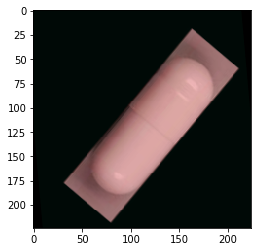

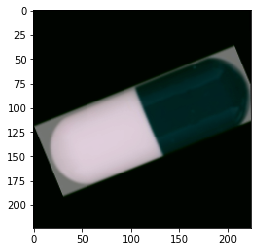

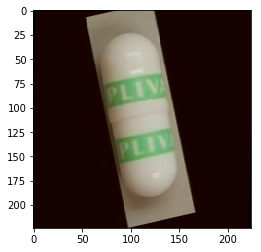

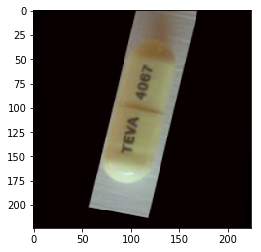

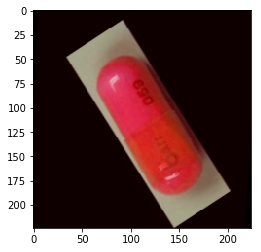

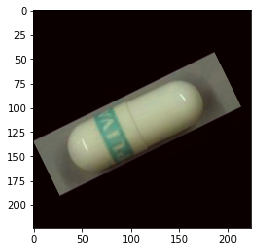

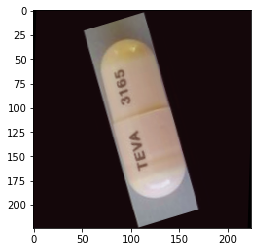

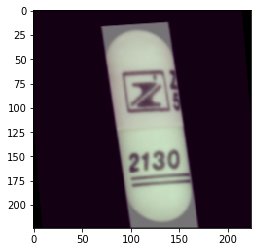

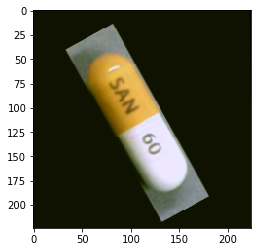

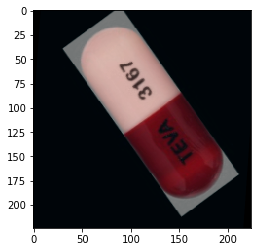

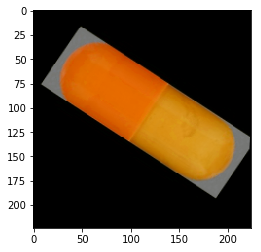

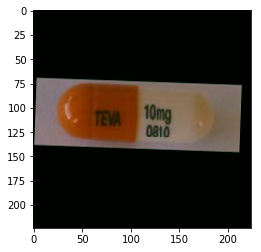

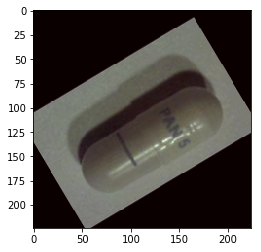

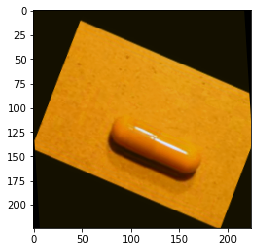

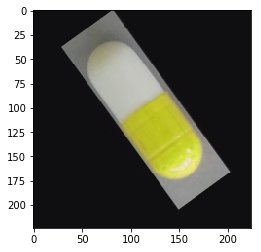

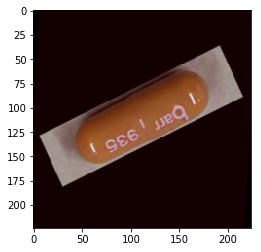

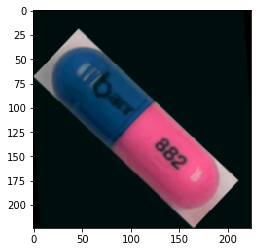

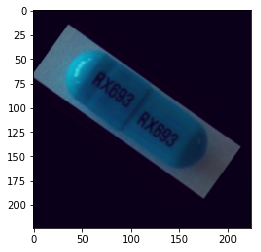

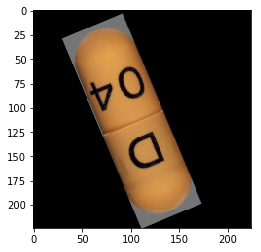

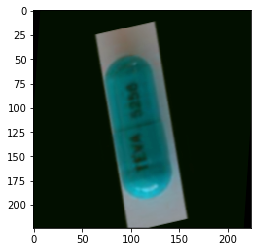

In [3]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
from imgaug import augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt

class PillDataset(Dataset):
    def __init__(self, df, label_encoder, labelcol='label', augment=False):
        self.df = df
        self.label_encoder = label_encoder
        self.augment = augment
        self.aug_iaa = iaa.Sequential([
            iaa.Sometimes(0.8, iaa.GaussianBlur(sigma=(0, 1.0))),
            iaa.Affine(rotate=(-180, 180),
                       scale=(0.9, 1.0),
                       translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}),
            iaa.AddToHueAndSaturation(value=(-20, 20), per_channel=True),
            iaa.ContrastNormalization((0.8, 1.2), per_channel=True),
            iaa.Sometimes(0.8, iaa.Affine(
                shear=(-5, 5),
            ))
        ]) 
        
        self.labelcol = labelcol
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
        ])

    def __getitem__(self, index):
        img_row = self.df.iloc[index]
        
        img_path = img_row.images
        img = self.load_img(img_path)
        img = Image.fromarray(img)
        img = self.transform(img)

        pill_label = img_row[self.labelcol]

        data = {
            'image': img,
            'label': self.label_encoder.transform([pill_label])[0],
            'pill_label': pill_label,
            'image_name': img_path
        }

        return data

    def __len__(self):
        return len(self.df)


    def load_img(self, img_path):
        if not os.path.exists(img_path):
            print("img not found", img_path)
            return

        img = np.asarray(Image.open(img_path))

        if self.augment:
            img = self.aug_iaa.augment_image(img)

        return img
    
image_datasets = {'train': PillDataset(train_df,
                                       label_encoder,
                                       augment=True),
                  'val': PillDataset(val_df,
                                     label_encoder,
                                     augment=False)}                  

dataloaders = {x: torch.utils.data.DataLoader(
    image_datasets[x], batch_size=args.batch_size,
    shuffle=(x == 'train')) for x in ['train', 'val']}

import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

# Get a batch of training data
batch = next(iter(dataloaders['train']))

print(batch['image'].shape, batch['label'], batch['pill_label'])

for i in range(20):
    plt.figure()
    plt.imshow(reverse_transform(batch['image'][i]))

In [5]:
import torch
import torch.nn as nn
import torch.optim
import time
import copy
from metrics import MetricsCollection, classification_accuracy
from tqdm import tqdm

# Azure ML
from azureml.core.run import Run
run = Run.get_context()

def train_model(model, criterion, optimizer, scheduler,
                device, dataloaders,
                label_encoder,
                num_epochs=100,
                earlystop_patience=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    has_waited = 0
    stop_training = False

    epoch_metrics = MetricsCollection()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            batch_metrics = MetricsCollection()
            predictions_list = []

            # Iterate over data.
            loader = dataloaders[phase]
            # tqdm disable=None for Azure ML (no progress-bar for non-tty)
            pbar = tqdm(loader, total=len(loader), desc="Epoch {} {}".format(epoch, phase), ncols=0) #, disable=None)
            for batch_index, batch_data in enumerate(pbar):
                inputs = batch_data['image'].to(device)
                labels = batch_data['label'].to(device)
                img_paths = batch_data['image_name']

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    loss = criterion(outputs, labels)
                    scores = outputs.softmax(1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
                        optimizer.step()

                batch_metrics.add(phase, 'loss', loss.item(), inputs.size(0))

                accuracies = classification_accuracy(outputs, labels, topk=(1, 5))
                batch_metrics.add(phase, 'top1-acc', accuracies[0].item(), inputs.size(0))
                batch_metrics.add(phase, 'top5-acc', accuracies[1].item(), inputs.size(0))

                pbar.set_postfix(**{k: "{:.5f}".format(meter.avg) for k, meter in batch_metrics[phase].items()})


            for key, meter in batch_metrics[phase].items():
                epoch_metrics.add(phase, key, meter.avg, 1)
                run.log('{}_{}'.format(phase, key), meter.avg)

            if phase == 'val':
                # monitor the val metrics
                best_epoch_index = epoch_metrics['val']['top1-acc'].best()[1]
                if best_epoch_index == epoch:
                    has_waited = 1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print("Saving the best model state dict")
                else:
                    if has_waited >= earlystop_patience:
                        print("** Early stop in training: {} waits **".format(has_waited))
                        stop_training = True

                    has_waited += 1

                if type(scheduler) is torch.optim.lr_scheduler.ReduceLROnPlateau:
                    scheduler.step(epoch_metrics['val']['loss'].value)
                else:
                    scheduler.step()

        print()  # end of epoch
        if stop_training:
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    best_acc, best_epoch = epoch_metrics['val']['top1-acc'].best()

    best_metrics = {
        'top1-acc': best_acc,
        'top5-acc': epoch_metrics['val']['top5-acc'].history[best_epoch],
    }

    for key, meter in epoch_metrics['val'].items():
        best_value, best_epoch = meter.best()
        train_value = epoch_metrics['train'][key].history[best_epoch]
        print('* Best val-{} at epoch {}: {:4f} (train-{}: {:4f}) *'.format(key, best_epoch, best_value, key, train_value))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_metrics

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

import resnet
model = resnet.BasicResNet(num_classes=len(label_encoder.classes_), network='resnet18')
model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=args.init_lr)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,
                                          factor=0.1,
                                          patience=1,
                                          verbose=True)

model, best_val_metrics = train_model(model, criterion, opt, scheduler, device, dataloaders, label_encoder)

Epoch 0 train:   0% 0/23 [00:00<?, ?it/s]

Epoch 0/99
----------


Epoch 0 train: 100% 23/23 [00:25<00:00,  1.08s/it, loss=5.27059, top1-acc=0.00605, top5-acc=0.04843]
Epoch 0 val:   0% 0/5 [00:00<?, ?it/s]

Attempted to log scalar metric train_loss:
5.27058967839719
Attempted to log scalar metric train_top1-acc:
0.006053268810233539
Attempted to log scalar metric train_top5-acc:
0.04842615128916487


Epoch 0 val: 100% 5/5 [00:03<00:00,  1.45it/s, loss=5.08578, top1-acc=0.01818, top5-acc=0.09697]
Epoch 1 train:   0% 0/23 [00:00<?, ?it/s]

Attempted to log scalar metric val_loss:
5.085777880928733
Attempted to log scalar metric val_top1-acc:
0.018181818385015834
Attempted to log scalar metric val_top5-acc:
0.09696969938549128
Saving the best model state dict

Epoch 1/99
----------


Epoch 1 train: 100% 23/23 [00:25<00:00,  1.09s/it, loss=4.90782, top1-acc=0.04237, top5-acc=0.12712]
Epoch 1 val:   0% 0/5 [00:00<?, ?it/s]

Attempted to log scalar metric train_loss:
4.907823067311802
Attempted to log scalar metric train_top1-acc:
0.04237288181595594
Attempted to log scalar metric train_top5-acc:
0.12711864635889525


Epoch 1 val: 100% 5/5 [00:05<00:00,  1.03it/s, loss=4.73542, top1-acc=0.07273, top5-acc=0.19394]
Epoch 2 train:   0% 0/23 [00:00<?, ?it/s]

Attempted to log scalar metric val_loss:
4.7354160222140225
Attempted to log scalar metric val_top1-acc:
0.07272727333686568
Attempted to log scalar metric val_top5-acc:
0.19393939728086645
Saving the best model state dict

Epoch 2/99
----------


Epoch 2 train: 100% 23/23 [00:35<00:00,  1.29s/it, loss=4.57293, top1-acc=0.07022, top5-acc=0.25182]
Epoch 2 val:   0% 0/5 [00:00<?, ?it/s]

Attempted to log scalar metric train_loss:
4.572932951098204
Attempted to log scalar metric train_top1-acc:
0.07021791931719815
Attempted to log scalar metric train_top5-acc:
0.2518159837324452


Epoch 2 val: 100% 5/5 [00:03<00:00,  1.43it/s, loss=4.40662, top1-acc=0.10909, top5-acc=0.32727]
Epoch 3 train:   0% 0/23 [00:00<?, ?it/s]

Attempted to log scalar metric val_loss:
4.406619245355779
Attempted to log scalar metric val_top1-acc:
0.10909091152928092
Attempted to log scalar metric val_top5-acc:
0.3272727324204011
Saving the best model state dict

Epoch 3/99
----------


Epoch 3 train: 100% 23/23 [00:25<00:00,  1.08s/it, loss=4.18727, top1-acc=0.14891, top5-acc=0.40920]
Epoch 3 val:   0% 0/5 [00:00<?, ?it/s]

Attempted to log scalar metric train_loss:
4.187267844959841
Attempted to log scalar metric train_top1-acc:
0.14891041523030538
Attempted to log scalar metric train_top5-acc:
0.4092009726361559


Epoch 3 val: 100% 5/5 [00:03<00:00,  1.41it/s, loss=4.07529, top1-acc=0.20000, top5-acc=0.49697]
Epoch 4 train:   0% 0/23 [00:00<?, ?it/s]

Attempted to log scalar metric val_loss:
4.075288321755149
Attempted to log scalar metric val_top1-acc:
0.20000000528313897
Attempted to log scalar metric val_top5-acc:
0.49696971069682727
Saving the best model state dict

Epoch 4/99
----------


Epoch 4 train: 100% 23/23 [00:25<00:00,  1.15s/it, loss=3.87690, top1-acc=0.22639, top5-acc=0.52300]
Epoch 4 val:   0% 0/5 [00:00<?, ?it/s]

Attempted to log scalar metric train_loss:
3.8768976202311296
Attempted to log scalar metric train_top1-acc:
0.22639225533380924
Attempted to log scalar metric train_top5-acc:
0.5230024328531999


Epoch 4 val: 100% 5/5 [00:03<00:00,  1.47it/s, loss=3.82389, top1-acc=0.23636, top5-acc=0.57576]
Epoch 5 train:   0% 0/23 [00:00<?, ?it/s]

Attempted to log scalar metric val_loss:
3.82388746955178
Attempted to log scalar metric val_top1-acc:
0.2363636390729384
Attempted to log scalar metric val_top5-acc:
0.5757575912909074
Saving the best model state dict

Epoch 5/99
----------


Epoch 5 train: 100% 23/23 [00:26<00:00,  1.45s/it, loss=3.55882, top1-acc=0.29903, top5-acc=0.63801]
Epoch 5 val:   0% 0/5 [00:00<?, ?it/s]

Attempted to log scalar metric train_loss:
3.5588225348521085
Attempted to log scalar metric train_top1-acc:
0.29903148118289274
Attempted to log scalar metric train_top5-acc:
0.6380145318860292


Epoch 5 val: 100% 5/5 [00:06<00:00,  1.15s/it, loss=3.50261, top1-acc=0.33939, top5-acc=0.69697]
Epoch 6 train:   0% 0/23 [00:00<?, ?it/s]

Attempted to log scalar metric val_loss:
3.5026096690784803
Attempted to log scalar metric val_top1-acc:
0.3393939397551797
Attempted to log scalar metric val_top5-acc:
0.6969697117805481
Saving the best model state dict

Epoch 6/99
----------


Epoch 6 train: 100% 23/23 [00:26<00:00,  1.08s/it, loss=3.28636, top1-acc=0.34262, top5-acc=0.72276]
Epoch 6 val:   0% 0/5 [00:00<?, ?it/s]

Attempted to log scalar metric train_loss:
3.2863579108120455
Attempted to log scalar metric train_top1-acc:
0.34261501373015074
Attempted to log scalar metric train_top5-acc:
0.7227602967627113


Epoch 6 val: 100% 5/5 [00:04<00:00,  1.26it/s, loss=3.27455, top1-acc=0.36970, top5-acc=0.73939]
Epoch 7 train:   0% 0/23 [00:00<?, ?it/s]

Attempted to log scalar metric val_loss:
3.274550689350475
Attempted to log scalar metric val_top1-acc:
0.3696969747543335
Attempted to log scalar metric val_top5-acc:
0.7393939516761087
Saving the best model state dict

Epoch 7/99
----------


Epoch 7 train: 100% 23/23 [00:28<00:00,  1.13s/it, loss=2.96171, top1-acc=0.43826, top5-acc=0.80630]
Epoch 7 val:   0% 0/5 [00:00<?, ?it/s]

Attempted to log scalar metric train_loss:
2.9617131264388705
Attempted to log scalar metric train_top1-acc:
0.43825665967805044
Attempted to log scalar metric train_top5-acc:
0.8062954051442642


Epoch 7 val: 100% 5/5 [00:03<00:00,  1.43it/s, loss=2.99817, top1-acc=0.47879, top5-acc=0.77576]
Epoch 8 train:   0% 0/23 [00:00<?, ?it/s]

Attempted to log scalar metric val_loss:
2.998169270428744
Attempted to log scalar metric val_top1-acc:
0.47878788384524257
Attempted to log scalar metric val_top5-acc:
0.775757576118816
Saving the best model state dict

Epoch 8/99
----------


Epoch 8 train: 100% 23/23 [00:25<00:00,  1.10s/it, loss=2.76009, top1-acc=0.48547, top5-acc=0.81598]
Epoch 8 val:   0% 0/5 [00:00<?, ?it/s]

Attempted to log scalar metric train_loss:
2.760093330471048
Attempted to log scalar metric train_top1-acc:
0.48547215842738856
Attempted to log scalar metric train_top5-acc:
0.8159806366116891


Epoch 8 val: 100% 5/5 [00:03<00:00,  1.41it/s, loss=2.81575, top1-acc=0.53939, top5-acc=0.85455]
Epoch 9 train:   0% 0/23 [00:00<?, ?it/s]

Attempted to log scalar metric val_loss:
2.815750993381847
Attempted to log scalar metric val_top1-acc:
0.5393939570947127
Attempted to log scalar metric val_top5-acc:
0.8545454567128962
Saving the best model state dict

Epoch 9/99
----------


Epoch 9 train: 100% 23/23 [00:25<00:00,  1.09s/it, loss=2.49090, top1-acc=0.55085, top5-acc=0.86562]
Epoch 9 val:   0% 0/5 [00:00<?, ?it/s]

Attempted to log scalar metric train_loss:
2.490903654052328
Attempted to log scalar metric train_top1-acc:
0.5508474571941552
Attempted to log scalar metric train_top5-acc:
0.8656174368777517


Epoch 9 val: 100% 5/5 [00:03<00:00,  1.46it/s, loss=2.56867, top1-acc=0.52121, top5-acc=0.83030]
Epoch 10 train:   0% 0/23 [00:00<?, ?it/s]

Attempted to log scalar metric val_loss:
2.568665396083485
Attempted to log scalar metric val_top1-acc:
0.5212121237408031
Attempted to log scalar metric val_top5-acc:
0.8303030241619457

Epoch 10/99
----------


Epoch 10 train:  74% 17/23 [00:18<00:06,  1.10s/it, loss=2.31879, top1-acc=0.58824, top5-acc=0.88235]

KeyboardInterrupt: 